## Load data

In [7]:
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoFeatureExtractor, AutoModel

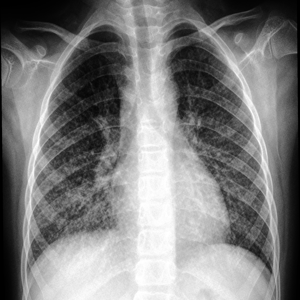

In [8]:
test_image_path = 'Covid19_dataset_project/Covid19_dataset_project/data/01/01.jpeg'
test_image = Image.open(test_image_path)
test_image_smaller = test_image.resize((300,300))
test_image_smaller

In [9]:
data_dir = 'Covid19_dataset_project/Covid19_dataset_project/data/'
class_dirs = ['01', '02', '03']

## Load Model

In [10]:



model_name = "microsoft/swin-tiny-patch4-window7-224"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

model = AutoModel.from_pretrained(model_name)


## Load images and extract features

In [11]:
# Function to extract features from an image
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0].squeeze().numpy()  # Using CLS token

In [12]:

features = []
labels = []

for class_idx, class_dir in enumerate(class_dirs):
    class_path = os.path.join(data_dir, class_dir)
    for image_file in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}"):
        image_path = os.path.join(class_path, image_file)
        try:
            feature = extract_features(image_path)
            features.append(feature)
            labels.append(class_idx)
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

Processing 03: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

In [14]:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [15]:
# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=3.0, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_dirs))

# If you want to save the trained model for later use
from joblib import dump
dump(svm_classifier, 'svm_model.joblib')
dump(scaler, 'scaler.joblib')

Accuracy: 0.8039

Classification Report:
              precision    recall  f1-score   support

          01       0.87      0.76      0.81        17
          02       0.85      0.73      0.79        15
          03       0.74      0.89      0.81        19

    accuracy                           0.80        51
   macro avg       0.82      0.80      0.80        51
weighted avg       0.81      0.80      0.80        51



['scaler.joblib']

### Without scaling

In [16]:


# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=3, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_dirs))


Accuracy: 0.8235

Classification Report:
              precision    recall  f1-score   support

          01       0.87      0.76      0.81        17
          02       0.86      0.80      0.83        15
          03       0.77      0.89      0.83        19

    accuracy                           0.82        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51



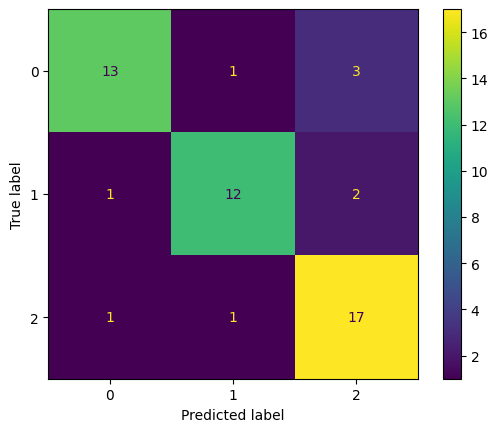

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Using PCR

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
pca.fit(X_train_scaled)
print(pca.explained_variance_ratio_)
#x_train_pca_pos = pca.transform(train_pos)
#x_train_pca_neg = pca.transform(train_neg)
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

[0.12794725 0.07912593 0.04644144 0.03870665 0.033686   0.03064115
 0.02726213 0.02648187 0.02517629 0.02336506 0.02118948 0.02058238
 0.01933444 0.0176372  0.01740449 0.01704632]


In [19]:
# Initialize and train the SVM classifier
svm_classifier = SVC(C=1.0, kernel='poly', degree=3, gamma=2)
svm_classifier.fit(x_train_pca, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(x_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_dirs))

Accuracy: 0.7451

Classification Report:
              precision    recall  f1-score   support

          01       0.65      1.00      0.79        17
          02       0.75      0.60      0.67        15
          03       0.92      0.63      0.75        19

    accuracy                           0.75        51
   macro avg       0.78      0.74      0.74        51
weighted avg       0.78      0.75      0.74        51



In [20]:

model_name = "nickmuchi/vit-finetuned-chest-xray-pneumonia"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


c:\Users\yochanan\.conda\envs\torch\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
c:\Users\yochanan\.conda\envs\torch\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTModel were not initialized from the model checkpoint at nickmuchi/vit-finetuned-chest-xray-pneumonia and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
features = []
labels = []

for class_idx, class_dir in enumerate(class_dirs):
    class_path = os.path.join(data_dir, class_dir)
    for image_file in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}"):
        image_path = os.path.join(class_path, image_file)
        try:
            feature = extract_features(image_path)
            features.append(feature)
            labels.append(class_idx)
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

Processing 03: 100%|██████████| 111/111 [00:21<00:00,  5.07it/s]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

In [23]:


# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_dirs))

# If you want to save the trained model for later use
from joblib import dump
dump(svm_classifier, 'svm_model.joblib')
dump(scaler, 'scaler.joblib')

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

          01       1.00      1.00      1.00        17
          02       1.00      1.00      1.00        15
          03       1.00      1.00      1.00        19

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



['scaler.joblib']

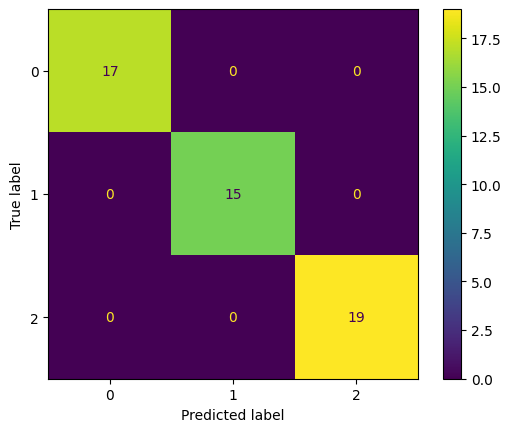

In [24]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

![alt text](image.png)
